# Implementation of GAN and cGAN

Here we are going to talk into the detail of what Generative Adversarial Network (GAN) and Conditional Generative Adversarial Network (cGAN) are. I will also explain and give an implementation both of them seperately. Code also can be obtained from my GitHub. Thanks so much to [*Rowel Atienza*](https://towardsdatascience.com/gan-by-example-using-keras-on-tensorflow-backend-1a6d515a60d0), [*Jason Brownlee*](https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/) and [*www.tensorflow.org*](https://www.tensorflow.org/tutorials/generative/dcgan) that inspired me from their articles. 

## Generative Adversarial Network (GAN)

Generative Adversarial Networks (GAN) is one of the most promising recent developments in Deep Learning. GAN, introduced by [Ian Goodfellow and friends](https://arxiv.org/abs/1406.2661) in 2014, attacks the problem of unsupervised learning by training two deep networks, called **Generator** and **Discriminator**, that compete and cooperate with each other. In the course of training, both networks eventually learn how to perform their tasks.

Figure 1 : A diagram of a generator and discriminator
![A diagram of a generator and discriminator](https://raw.githubusercontent.com/rauzansumara/gan-and-cgan/master/images/gan1.png "A diagram of a generator and discriminator") 
*Source: https://www.tensorflow.org/*

While the idea of GAN is simple in theory, it is very difficult to build a model that works. In GAN, there are two deep networks coupled together making back propagation of gradients twice as challenging. Deep Convolutional GAN (DCGAN) is one of the models that demonstrated how to build a practical GAN that is able to learn by itself how to synthesize new images. 

In this article, we discuss how a working GAN can be built using Keras on Tensorflow 2.x backend. We will train a DCGAN to learn how to write handwritten digits on the MNIST dataset.

### Setup library

In [44]:
import os
import PIL
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, Sequential, optimizers, losses
from tensorflow.keras.layers import Dense, Reshape, Conv2DTranspose, Conv2D
from tensorflow.keras.layers import LeakyReLU, Dropout, Flatten
from tensorflow.keras.layers import BatchNormalization
from IPython import display
tf.__version__

'2.4.0'

### Load the dataset

We will use the MNIST dataset to train the **generator** and the **discriminator**. The generator will generate handwritten digits resembling the MNIST data.

In [45]:
(train_images, train_labels), (_, _) = datasets.mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### The Discriminator model

A discriminator that tells how real image is, is basically a deep Convolutional Neural Network (CNN) as shown in Figure 2. The discriminator model takes as input one 28×28 grayscale image and outputs a binary prediction as to whether the image is real (class=1) or fake (class=0). It is implemented as a modest convolutional neural network using best practices for GAN design such as using the LeakyReLU activation function, using a 2×2 stride to downsample. The activation function used in each CNN layer is a leaky ReLU. A dropout between 0.3 and 0.3 between layers prevent over fitting and memorization.

Figure 2 : The Discriminator

![The discriminator](https://raw.githubusercontent.com/rauzansumara/gan-and-cgan/master/images/Discriminator.png "The discriminator") 

*Source:* [*Rowel Atienza*](https://towardsdatascience.com/gan-by-example-using-keras-on-tensorflow-backend-1a6d515a60d0)




In [46]:
def make_discriminator_model():
    model = Sequential()
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1))

    return model

### The Generator model

The generator synthesizes fake images. In Figure 3, the fake image is generated from a 100-dimensional noise (uniform distribution between -1.0 to 1.0) using the inverse of convolution, called transposed convolution. Instead of fractionally-strided convolution as suggested in DCGAN, upsampling between the first three layers is used since it synthesizes more realistic handwriting images. In between layers, batch normalization stabilizes learning. The activation function after each layer is a LeakyReLU. The output of the tanh at the last layer produces the fake image. 

Figure 3 : The Generator
![The Generator](https://raw.githubusercontent.com/rauzansumara/gan-and-cgan/master/images/Generator.png "The Generator") 

*Source:* [*Rowel Atienza*](https://towardsdatascience.com/gan-by-example-using-keras-on-tensorflow-backend-1a6d515a60d0)


In [47]:
def make_generator_model():
    model = Sequential()
    model.add(Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

### Define the loss and optimizers

Define loss functions and optimizers for both models.

In [48]:
# Define the loss and optimizers
cross_entropy = losses.BinaryCrossentropy(from_logits=True)

# Discriminator loss
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# Generator loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = optimizers.Adam(1e-4)
discriminator_optimizer = optimizers.Adam(1e-4)

### Training 

So far, there are no models yet. It is time to build the models for training. We need two models: 1) Discriminator Model  and 2) Generator-Discriminator model. The generator-discriminator stacked together as shown in Figure 4. The Generator part is trying to fool the Discriminator and learning from its feedback at the same time. The training parameters are the same as in the Discriminator model except for a reduced learning rate and corresponding weight decay.

Training is the hardest part. We determine first if Discriminator model is correct by training it alone with real and fake images. Afterwards, the Discriminator and Generator-Discriminator model are trained one after the other.

Figure 4 : The Training Process

![The Training Process](https://raw.githubusercontent.com/rauzansumara/gan-and-cgan/master/images/gan2.png "The Training Process")

*Source:* [*Rowel Atienza*](https://towardsdatascience.com/gan-by-example-using-keras-on-tensorflow-backend-1a6d515a60d0)


In [49]:
# Define the training loop
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# Define generator and discriminator
generator = make_generator_model()
discriminator = make_discriminator_model()

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

# Training steps
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

# Generate and save images
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about 3 minutes / epoch with the default settings on Colab.

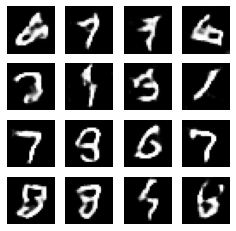

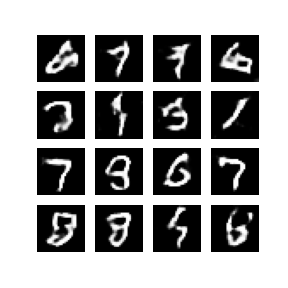

In [50]:
# This notebook also demonstrates how to save and restore models, 
# which can be helpful in case a long running training task is interrupted.
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

train(train_dataset, EPOCHS) # train process

# Display a single image using the epoch number
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

display_image(EPOCHS) # display created images

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Conditional Generative Adversarial Network (cGAN)

Generative Adversarial Networks, or GANs, are an architecture for training generative models, such as deep convolutional neural networks for generating images. Although GAN models are capable of generating new random plausible examples for a given dataset, there is no way to control the types of images that are generated other than trying to figure out the complex relationship between the latent space input to the generator and the generated images.

The conditional generative adversarial network, or cGAN for short, is a type of GAN that involves the conditional generation of images by a generator model. Image generation can be conditional on a class label, if available, allowing the targeted generated of images of a given type.

For example, the MNIST handwritten digit dataset has class labels of the corresponding integers, the CIFAR-10 small object photograph dataset has class labels for the corresponding objects in the photographs, and the Fashion-MNIST clothing dataset has class labels for the corresponding items of clothing.

There are two motivations for making use of the class label information in a GAN model.

 * Improve the GAN.
 * Targeted Image Generation.

Additional information that is correlated with the input images, such as class labels, can be used to improve the GAN. This improvement may come in the form of more stable training, faster training, and/or generated images that have better quality. Class labels can also be used for the deliberate or targeted generation of images of a given type.

Alternately, a GAN can be trained in such a way that both the generator and the discriminator models are conditioned on the class label. This means that when the trained generator model is used as a standalone model to generate images in the domain, images of a given type, or class label, can be generated.

The cGAN was first described by Mehdi Mirza and Simon Osindero in their 2014 paper titled [*“Conditional Generative Adversarial Nets.”*](https://arxiv.org/abs/1411.1784) In the paper, the authors motivate the approach based on the desire to direct the image generation process of the generator model.

Figure 5 : The cGAN

![The cGAN](https://raw.githubusercontent.com/rauzansumara/gan-and-cgan/master/images/cgan.png "The cGAN")

*Source:* [*Jason Brownlee*](https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/)

And now we will also discuss how cGAN can be built using Keras on Tensorflow 2.x backend. We will train a the model to learn how to write handwritten digits on the MNIST dataset as well.



### Setup library

In [22]:
# Import library
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from matplotlib import pyplot
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras import datasets, Sequential, optimizers, losses
from tensorflow.keras.layers import Dense, Reshape, Conv2DTranspose, Conv2D
from tensorflow.keras.layers import LeakyReLU, Dropout, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import load_model



### Load the dataset

In [23]:
# example of loading the MNIST dataset
(trainX, trainy), (testX, testy) = datasets.mnist.load_data()

# summarize the shape of the dataset
print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)

Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


### Define the discriminator model

The discriminator model takes as input one 28×28 grayscale image and outputs a binary prediction as to whether the image is real (class=1) or fake (class=0). It is implemented as a modest convolutional neural network using best practices for GAN design such as using the LeakyReLU activation function, using a 2×2 stride to downsample, and the adam version of stochastic gradient descent with a learning rate of 0.0001.

The *define_discriminator()* function below implements this, defining and compiling the discriminator model and returning it. The input shape of the image is parameterized as a default function argument in case you want to re-use the function for your own image data later.

In [32]:
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
    model = Sequential()

    # downsample
    model.add(Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    # downsample
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    # classifier
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    
    # compile model
    opt = optimizers.Adam(lr=1e-4)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

### Define the generator model

The generator model takes as input a point in the latent space and outputs a single 28×28 grayscale image. This is achieved by using a fully connected layer to interpret the point in the latent space and provide sufficient activations that can be reshaped into many copies (in this case 128) of a low-resolution version of the output image (e.g. 7×7). This is then upsampled twice, doubling the size and quadrupling the area of the activations each time using transpose convolutional layers. The model uses best practices such as the LeakyReLU activation, a kernel size that is a factor of the stride size, and a hyperbolic tangent (tanh) activation function in the output layer.

The define_generator() function below defines the generator model, but intentionally does not compile it as it is not trained directly, then returns the model. The size of the latent space is parameterized as a function argument.

In [33]:
# define the standalone generator model
def define_generator(latent_dim):
    model = Sequential()

    # foundation for 7x7 image
    n_nodes = 256 * 7 * 7
    model.add(Dense(n_nodes, use_bias=False, input_dim=latent_dim))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Reshape((7, 7, 256)))

    # upsample to 14x14
    model.add(Conv2DTranspose(64, (5,5), strides=(1,1), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    # upsample to 28x28
    model.add(Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    # generate
    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

### The cGAN model

Next, a cGAN model can be defined that combines both the generator model and the discriminator model into one larger model. This larger model will be used to train the model weights in the generator, using the output and error calculated by the discriminator model. The discriminator model is trained separately, and as such, the model weights are marked as not trainable in this larger GAN model to ensure that only the weights of the generator model are updated. This change to the trainability of the discriminator weights only has an effect when training the combined GAN model, not when training the discriminator standalone.

This larger cGAN model takes as input a point in the latent space, uses the generator model to generate an image which is fed as input to the discriminator model, then is output or classified as real or fake.

The *define_gan()* function below implements this, taking the already-defined generator and discriminator models as input.

In [35]:
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False

    # connect them
    model = Sequential()

    # add generator
    model.add(generator)

    # add the discriminator
    model.add(discriminator)
    
    # compile model
    opt = optimizers.Adam(lr=1e-4)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

### Load and generate function

Now that we have defined the cGAN model, we need to train it. But, before we can train the model, we require input data.

* The first step is to load and prepare the Fashion MNIST dataset. We only require the images in the training dataset. The images are black and white, therefore we must add an additional channel dimension to transform them to be three dimensional, as expected by the convolutional layers of our models. Finally, the pixel values must be scaled to the range [-1,1] to match the output of the generator model. *The load_real_samples()* function below implements this, returning the loaded and scaled MNIST training dataset ready for modeling.

* We will require one batch (or a half) batch of real images from the dataset each update to the cGAN model. A simple way to achieve this is to select a random sample of images from the dataset each time. *The generate_real_samples()* function below implements this, taking the prepared dataset as an argument, selecting and returning a random sample of MNIST images and their corresponding class label for the discriminator, specifically class=1, indicating that they are real images.

* Next, we need inputs for the generator model. These are random points from the latent space, specifically Gaussian distributed random variables. *The generate_latent_points()* function implements this, taking the size of the latent space as an argument and the number of points required and returning them as a batch of input samples for the generator model.

* Next, we need to use the points in the latent space as input to the generator in order to generate new images. *The generate_fake_samples()* function below implements this, taking the generator model and size of the latent space as arguments, then generating points in the latent space and using them as input to the generator model. The function returns the generated images and their corresponding class label for the discriminator model, specifically class=0 to indicate they are fake or generated.

In [38]:
# load real samples
def load_real_samples():
	# load dataset
	(trainX, _), (_, _) = datasets.mnist.load_data()
	# expand to 3d, e.g. add channels
	X = expand_dims(trainX, axis=-1)
	# convert from ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return X

# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# select images
	X = dataset[ix]
	# generate class labels
	y = ones((n_samples, 1))
	return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels
	y = zeros((n_samples, 1))
	return X, y

### Training model

We are now ready to fit the cGAN models.

The model is fit for 100 training epochs, which is arbitrary, as the model begins generating plausible handwriten digits after perhaps 20 epochs. A batch size of 128 samples is used, and each training epoch involves 60,000/128, or about 468 batches of real and fake samples and updates to the model.

First, the discriminator model is updated for a half batch of real samples, then a half batch of fake samples, together forming one batch of weight updates. The generator is then updated via the composite gan model. Importantly, the class label is set to 1 or real for the fake samples. This has the effect of updating the generator toward getting better at generating real samples on the next batch.

The *train()* function below implements this, taking the defined models, dataset, and size of the latent dimension as arguments and parameterizing the number of epochs and batch size with default arguments. The generator model is saved at the end of training.

In [40]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
	# save the generator model
	g_model.save('generator.h5')
 
# size of the latent space
latent_dim = 16
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()
# train model
train(generator, discriminator, gan_model, dataset, latent_dim)



>99, 458/468, d1=0.655, d2=0.662 g=0.804
>99, 459/468, d1=0.639, d2=0.653 g=0.779
>99, 460/468, d1=0.674, d2=0.618 g=0.819
>99, 461/468, d1=0.634, d2=0.682 g=0.814
>99, 462/468, d1=0.673, d2=0.676 g=0.788
>99, 463/468, d1=0.644, d2=0.644 g=0.833
>99, 464/468, d1=0.681, d2=0.655 g=0.823
>99, 465/468, d1=0.660, d2=0.652 g=0.786
>99, 466/468, d1=0.648, d2=0.606 g=0.781
>99, 467/468, d1=0.645, d2=0.663 g=0.830
>99, 468/468, d1=0.658, d2=0.626 g=0.784
>100, 1/468, d1=0.691, d2=0.649 g=0.809
>100, 2/468, d1=0.633, d2=0.653 g=0.810
>100, 3/468, d1=0.693, d2=0.630 g=0.794
>100, 4/468, d1=0.656, d2=0.686 g=0.799
>100, 5/468, d1=0.696, d2=0.631 g=0.792
>100, 6/468, d1=0.642, d2=0.691 g=0.757
>100, 7/468, d1=0.677, d2=0.696 g=0.806
>100, 8/468, d1=0.650, d2=0.627 g=0.811
>100, 9/468, d1=0.673, d2=0.657 g=0.800
>100, 10/468, d1=0.709, d2=0.618 g=0.779
>100, 11/468, d1=0.645, d2=0.658 g=0.836
>100, 12/468, d1=0.660, d2=0.645 g=0.837
>100, 13/468, d1=0.689, d2=0.600 g=0.781
>100, 14/468, d1=0.658, 

### Generate 16 random handwritten digits

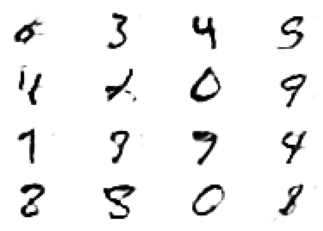

In [43]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 
# create and save a plot of generated images (reversed grayscale)
def show_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	pyplot.show()
 
# load model
model = load_model('generator.h5')
# generate images
latent_points = generate_latent_points(16, 16)
# generate images
X = model.predict(latent_points)
# plot the result
show_plot(X, 4)